In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, mean_squared_error

from src.xg_model_base import XGModel

## Extra Tree Classifier

In [2]:
model = XGModel("../data", model=ExtraTreesRegressor(n_jobs=4), dummy=True)
model.fit(params=dict(max_depth=20, n_estimators=300, min_samples_split=256), normalize=True)
model.save(Path("../models/xg_extra_trees.pkl"))

In [3]:
model = XGModel("../data", model="../models/xg_extra_trees.pkl")

In [4]:
zipped = zip(model.x_train.columns, model._model.feature_importances_)
for feature, importance in sorted(zipped, key=lambda k: k[1]):
    print(feature, importance)

prev_event_type-GOAL 0.0009110312842213805
prev_event_type-PENALTY 0.0015314809920733451
prev_event_type-BLOCKED_SHOT 0.0028741141848779485
prev_event_type-MISSED_SHOT 0.0029449213926640927
prev_event_type-TAKEAWAY 0.0034789807743402603
shot_type-Wrap-around 0.004027257504963613
prev_event_type-HIT 0.004523668727316473
is_home 0.004781935095544246
prev_event_type-FACEOFF 0.004983972020917016
prev_event_type-GIVEAWAY 0.007226239417201555
prev_event_same_team 0.012724146925627487
distance_change 0.01399142353014663
goal_diff 0.014234343248445533
angle_change 0.01662215329450795
prev_event_type-SHOT 0.019901203874200413
shot_type-Slap 0.03426701594686972
shot_type-Deflected 0.035753573382982635
strength_active 0.04310303830998788
strength_opp 0.04532228556192371
shot_type-Tip-In 0.0526178071478337
shot_type-Backhand 0.055634526238566726
shot_type-Snap 0.05597477183329321
time_change 0.05770580507259283
angle 0.08947928150448205
shot_type-Wrist 0.10048012383633965
empty_net_opp 0.129819468

--> Extra Tree Regression:
train: AUC: 0.8687; RMSE: 0.0522


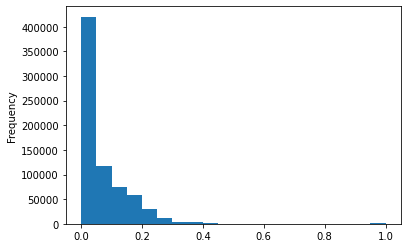

test: AUC: 0.8387; RMSE: 0.0544


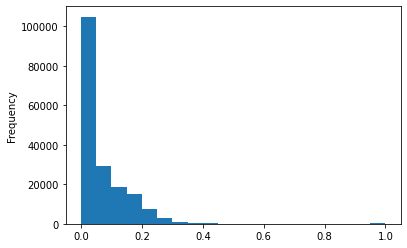

In [5]:
print("--> Extra Tree Regression:")
for ds_type in ['train', 'test']:
    print(ds_type, end=": ")
    x = model.get_norm_train_ds() if ds_type == "train" else model.get_norm_test_ds()
    y_true = model.y_train if ds_type == "train" else model.y_test
    y_xg = model.predict(x)
    y_xg.index = y_true.index
    print(f"AUC: {roc_auc_score(y_true, y_xg):.4f}; RMSE: {mean_squared_error(y_true, y_xg):.4f}")
    y_xg.plot.hist(bins=20)
    plt.show()

## Logistic Regression

In [10]:
model = XGModel("../data", model=LogisticRegression())
model.fit(params=dict(penalty='l2', class_weight="balanced", max_iter=1000, C=0.01), normalize=True)

In [14]:
zipped = zip(model.x_train.columns, model._model.coef_[0])
for feature, importance in sorted(zipped, key=lambda k: k[1]):
    print(feature, importance)

strength_opp -0.311782003766321
prev_event_type-FACEOFF -0.13311440323235857
prev_event_type-HIT -0.08940779022757825
time_change -0.05200950384027587
distance -0.03642993235366137
distance_change -0.010519458350392382
prev_event_type-MISSED_SHOT -6.549253407686296e-05
prev_event_type-GOAL 3.985507590666483e-06
angle_change 5.546475039951439e-05
angle 0.005582166557589552
prev_event_type-PENALTY 0.008051283155980221
prev_event_type-BLOCKED_SHOT 0.01347845983674697
is_home 0.020294418951442482
prev_event_same_team 0.02389725803227724
prev_event_type-TAKEAWAY 0.04229121541154048
goal_diff 0.051385689524445756
strength_active 0.053651119740958486
prev_event_type-GIVEAWAY 0.0882033532792534
prev_event_type-SHOT 0.1351735502274971
empty_net_opp 0.31468930971392844
shot_type-Wrap-around 0.5211008343307112
shot_type-Deflected 0.7229024334755643
shot_type-Tip-In 1.2454746799062109
shot_type-Backhand 1.484260973551732
shot_type-Snap 1.8761943461668797
shot_type-Slap 1.9085177103429305
shot_type

--> Logistic Regression:
train: AUC: 0.7639; RMSE: 0.2098


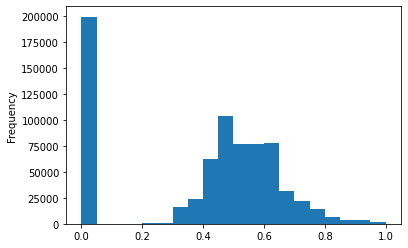

test: AUC: 0.7621; RMSE: 0.2096


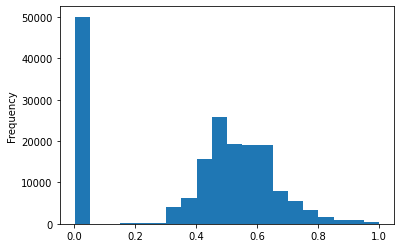

In [11]:
print("--> Logistic Regression:")
for ds_type in ['train', 'test']:
    print(ds_type, end=": ")
    x = model.get_norm_train_ds() if ds_type == "train" else model.get_norm_test_ds()
    y_true = model.y_train if ds_type == "train" else model.y_test
    y_xg = model.predict_xg(x)
    y_xg.index = y_true.index
    print(f"AUC: {roc_auc_score(y_true, y_xg):.4f}; RMSE: {mean_squared_error(y_true, y_xg):.4f}")
    y_xg.plot.hist(bins=20)
    plt.show()


## Neural Network

In [2]:
from src.xg_model_nn import XGModelNN
import tensorflow as tf
import seaborn as sns
import pandas as pd
print(tf.test.gpu_device_name())

/device:GPU:0


In [3]:
model = XGModelNN("../data", hidden_layers="64-256-64-16-8", dropout=0.2)
history = model.fit(n_epochs=50, batch_size=256, verbose=0)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/50
2256/2256 [==============================] - 10s 3ms/step - loss: 0.0244 - auc: 0.7598 - root_mean_squared_error: 0.4592 - val_loss: 0.2051 - val_auc: 0.8074 - val_root_mean_squared_error: 0.4529

<AxesSubplot:ylabel='auc'>

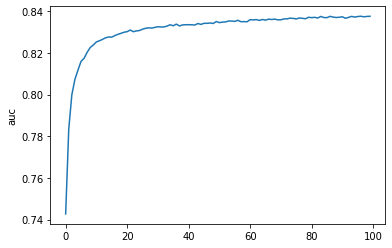

In [11]:
df_history = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=df_history, x=df_history.index, y="auc")


--> MLP:
train: AUC: 0.7090; RMSE: 0.4100


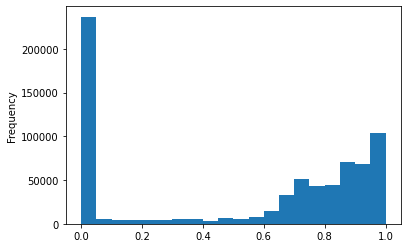

outcome    227778
0          227778
dtype: int64
test: AUC: 0.7054; RMSE: 0.4088


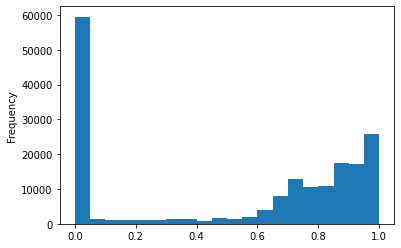

outcome    57204
0          57204
dtype: int64


In [4]:
print("--> MLP:")
for ds_type in ['train', 'test']:
    print(ds_type, end=": ")
    x = model.get_norm_train_ds() if ds_type == "train" else model.get_norm_test_ds()
    y_true = model.y_train if ds_type == "train" else model.y_test
    y_xg = model.predict_xg(x)
    y_xg.index = y_true.index
    print(f"AUC: {roc_auc_score(y_true, y_xg):.4f}; RMSE: {mean_squared_error(y_true, y_xg):.4f}")
    y_xg.plot.hist(bins=20)
    plt.show()
    both = pd.concat([y_true, y_xg], axis='columns')
    print(both[both[0] < 0.01].count())